# Model Training - MobileNetV3 (transfer + data augmentation) balanced

### 0. Imports

In [25]:
import numpy as np

from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.metrics import Precision, Recall
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.utils.class_weight import compute_class_weight

### 1. Paths

In [26]:
# DATASET_BASE_TRAIN_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_resized"
# DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged"
DATASET_BASE_TRAIN_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/train_merged_cleaned"

# DATASET_BASE_TRAIN_PATH = "../new_data"

# DATASET_BASE_TEST_PATH = "/Users/adamdabkowski/DataspellProjects/Praca_dyplomowa/data/test_resized"
DATASET_BASE_TEST_PATH = "/Users/adamd/DataspellProjects/Facial Expressions Recognition/data/test_resized"

### 2. Data preprocessing

In [10]:
batch_size  = 32
img_size = 224

train_validation_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
)

validation_generator = train_validation_data_generator.flow_from_directory(
    DATASET_BASE_TRAIN_PATH,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=True,
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

Found 23689 images belonging to 7 classes.
Found 5919 images belonging to 7 classes.


In [11]:
class_weights_dict

{0: 1.0264309545474242,
 1: 6.701272984441301,
 2: 1.0027089947089947,
 3: 0.5746549256483031,
 4: 0.8318935243714005,
 5: 0.8679514893928846,
 6: 1.2741501721170396}

### 5. Model creating

In [12]:
CATEGORIES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [13]:
checkpoint = ModelCheckpoint(
    filepath="./model_mobilenet_v3_transfer_data_augmentation_balanced.h5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=0.00001,
)

callbacks_list = [early_stopping, checkpoint, reduce_learning_rate]

In [14]:
model = Sequential()

base_model = MobileNetV3Large(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        "accuracy",
        "categorical_accuracy",
        Precision(name='precision'),
        Precision(class_id=0, name='precision_angry'),
        Precision(class_id=1, name='precision_disgust'),
        Precision(class_id=2, name='precision_fear'),
        Precision(class_id=3, name='precision_happy'),
        Precision(class_id=4, name='precision_neutral'),
        Precision(class_id=5, name='precision_sad'),
        Precision(class_id=6, name='precision_surprise'),
        Recall(name='recall'),
        Recall(class_id=0, name='recall_angry'),
        Recall(class_id=1, name='recall_disgust'),
        Recall(class_id=2, name='recall_fear'),
        Recall(class_id=3, name='recall_happy'),
        Recall(class_id=4, name='recall_neutral'),
        Recall(class_id=5, name='recall_sad'),
        Recall(class_id=6, name='recall_surprise'),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               492032    
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 3,491,975
Trainable params: 3,467,575
Non-trainable params: 24,400
_________________________________________________________________


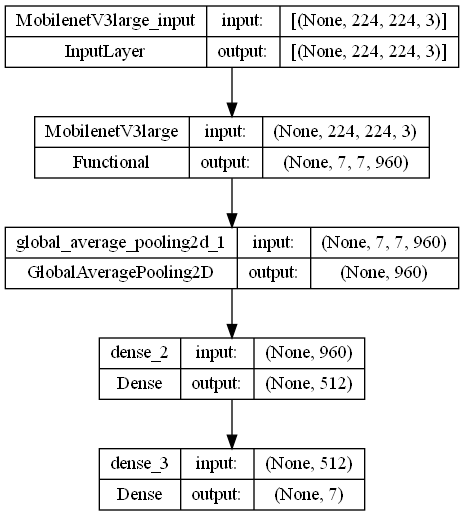

In [16]:
plot_model(model, to_file='model_mobilenet_v3_transfer_data_augmentation_balanced.png', show_shapes=True, show_layer_names=True)

### 6. Model training

In [17]:
epochs = 50

In [18]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
)

Epoch 1/50
740/740 [==============================] - ETA: 0s - loss: 1.4987 - accuracy: 0.4320 - categorical_accuracy: 0.4320 - precision: 0.6819 - precision_angry: 0.5208 - precision_disgust: 0.2478 - precision_fear: 0.4762 - precision_happy: 0.8580 - precision_neutral: 0.5858 - precision_sad: 0.5188 - precision_surprise: 0.6565 - recall: 0.2092 - recall_angry: 0.0380 - recall_disgust: 0.3327 - recall_fear: 0.0089 - recall_happy: 0.4417 - recall_neutral: 0.1386 - recall_sad: 0.0354 - recall_surprise: 0.5008
Epoch 1: val_loss improved from inf to 2.61754, saving model to .\model_mobilenet_v3_transfer_data_augmentation_balanced_2.h5
740/740 [==============================] - 1101s 1s/step - loss: 1.4987 - accuracy: 0.4320 - categorical_accuracy: 0.4320 - precision: 0.6819 - precision_angry: 0.5208 - precision_disgust: 0.2478 - precision_fear: 0.4762 - precision_happy: 0.8580 - precision_neutral: 0.5858 - precision_sad: 0.5188 - precision_surprise: 0.6565 - recall: 0.2092 - recall_angry

### 7. Evaluation - Test set

In [27]:
from keras.models import load_model

model = load_model("model_mobilenet_v3_transfer_data_augmentation_balanced.h5")

In [28]:
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    DATASET_BASE_TEST_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7178 images belonging to 7 classes.


In [29]:
model.evaluate(test_generator)

225/225 [==============================] - 132s 393ms/step - loss: 0.9356 - accuracy: 0.6900 - categorical_accuracy: 0.6900 - precision: 0.7394 - precision_angry: 0.6651 - precision_disgust: 0.7590 - precision_fear: 0.6155 - precision_happy: 0.9148 - precision_neutral: 0.6664 - precision_sad: 0.6241 - precision_surprise: 0.7963 - recall: 0.6399 - recall_angry: 0.5825 - recall_disgust: 0.5676 - recall_fear: 0.3799 - recall_happy: 0.8591 - recall_neutral: 0.6448 - recall_sad: 0.4900 - recall_surprise: 0.7858


[0.9355986714363098,
 0.6900250911712646,
 0.6900250911712646,
 0.7393754124641418,
 0.6650774478912354,
 0.759036123752594,
 0.6155063509941101,
 0.9147658944129944,
 0.6663872599601746,
 0.624106228351593,
 0.7963414788246155,
 0.6398718357086182,
 0.5824634432792664,
 0.5675675868988037,
 0.3798828125,
 0.8590755462646484,
 0.6447688341140747,
 0.4899759292602539,
 0.7858002185821533]